In [127]:
%matplotlib inline
from tqdm import tqdm
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

import json
import math

In [128]:

def FOM(error_in,y_ref,dfreg=None):
    #y_ref = [i for i in y_ref if i != 0]
    #y_ref=y_ref[y_ref!=0]
    ind=np.where(y_ref != 0)[0]
    #y_ref=y_ref.iloc[ind]
    #error_in=error_in.iloc[ind]
    y_tilde=y_ref-np.mean(y_ref)
    r_squared=1-(error_in.T.dot(error_in)/y_tilde.T.dot(y_tilde))
    N=np.size(y_ref)
    
    if dfreg is None:
        print("Outputting RMSEP")
        rmse=math.sqrt(error_in.T.dot(error_in)/N)
    else:
        print("Outputting RMSEC") 
        rmse=math.sqrt(error_in.T.dot(error_in)/(N-dfreg))
    bias=np.mean(error_in)
    error=np.mean(abs(error_in))
    #y_ref1=[i for i in y_ref if i != 0]
    
    normal_bias=np.mean(100*(error_in/y_ref))
    normal_error=np.mean(100*abs(error_in/y_ref))
    data={ 'R_sqrd': [r_squared], 'RMSE':[rmse], 'Bias':[bias],'Norm_Bias':[normal_bias],'Error':[error],'Norm_Error':[normal_error]}
    df = pd.DataFrame(data=data)
    #df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    
    return df.astype(np.float64)

In [129]:
train = pd.read_csv('features_train_1.csv')
test = pd.read_csv('features_test_1.csv')

In [130]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454692 entries, 0 to 1454691
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1454692 non-null  object 
 1   vendor_id           1454692 non-null  int64  
 2   passenger_count     1454692 non-null  int64  
 3   pickup_longitude    1454692 non-null  float64
 4   pickup_latitude     1454692 non-null  float64
 5   dropoff_longitude   1454692 non-null  float64
 6   dropoff_latitude    1454692 non-null  float64
 7   trip_duration       1454692 non-null  int64  
 8   pick_month          1454692 non-null  int64  
 9   hour                1454692 non-null  int64  
 10  day_of_month        1454692 non-null  int64  
 11  day_of_week         1454692 non-null  int64  
 12  all_precip          1454692 non-null  float64
 13  has_precip          1454692 non-null  int64  
 14  distance_haversine  1454692 non-null  float64
 15  distance_manhat

In [131]:
#test.info()

In [132]:
train['vendor_id'] = train['vendor_id'].astype(str)
test['vendor_id'] = test['vendor_id'].astype(str)

train['has_precip'] = train['has_precip'].astype(str)
test['has_precip'] = test['has_precip'].astype(str)

train['fast_hour'] = train['fast_hour'].astype(str)
test['fast_hour'] = test['fast_hour'].astype(str)

train['holiday'] = train['holiday'].astype(str)
test['holiday'] = test['holiday'].astype(str)

train['weekday'] = train['weekday'].astype(str)
test['weekday'] = test['weekday'].astype(str)



train['pick_month'] = train['pick_month'].astype(str)
test['pick_month'] = test['pick_month'].astype(str)

#train['day_of_month'] = train['day_of_month'].astype(str)
#test['day_of_month'] = test['day_of_month'].astype(str)

train['day_of_week'] = train['day_of_week'].astype(str)
test['day_of_week'] = test['day_of_week'].astype(str)



In [133]:
train.head(3)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_month,hour,day_of_month,day_of_week,all_precip,has_precip,distance_haversine,distance_manhattan,fast_hour,holiday,weekday
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,17,14,0,0.29,1,1.498521,1.735433,0,0,1
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,0,12,6,0.35,1,1.805507,2.430506,0,1,0
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,11,19,1,0.00,0,6.385098,8.203575,0,0,1


In [134]:
#train.info()

In [135]:
#train.columns

In [136]:
test.head(3)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pick_month,hour,day_of_month,day_of_week,all_precip,has_precip,distance_haversine,distance_manhattan,fast_hour,holiday,weekday
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,3,17,14,0,0.29,1,2.746426,2.913304,0,0,1
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,6,0,12,6,0.35,1,2.759239,3.104805,0,1,0
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,1,11,19,1,0.00,0,1.306155,1.846340,0,0,1


In [137]:
test.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pick_month', 'hour', 'day_of_month', 'day_of_week', 'all_precip',
       'has_precip', 'distance_haversine', 'distance_manhattan', 'fast_hour',
       'holiday', 'weekday'],
      dtype='object')

In [138]:
do_not_use_for_training = ['id','trip_duration']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [139]:
print(len(feature_names)) 
feature_names

17


['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pick_month',
 'hour',
 'day_of_month',
 'day_of_week',
 'all_precip',
 'has_precip',
 'distance_haversine',
 'distance_manhattan',
 'fast_hour',
 'holiday',
 'weekday']

In [140]:
y = np.log(train['trip_duration'].values + 1)

In [141]:
dtrain = train[feature_names]
dtest = test[feature_names]

In [142]:
print(dtest.shape)
print(test.shape)

(625111, 17)
(625111, 18)


In [143]:
dtrain.isnull().sum()

vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
pick_month            0
hour                  0
day_of_month          0
day_of_week           0
all_precip            0
has_precip            0
distance_haversine    0
distance_manhattan    0
fast_hour             0
holiday               0
weekday               0
dtype: int64

In [144]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

In [145]:
cat_cols

['vendor_id',
 'pick_month',
 'day_of_week',
 'has_precip',
 'fast_hour',
 'holiday',
 'weekday']

In [146]:
#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])
X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

In [147]:
my_pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# Transform the data
X_train_xgb = my_pipeline.fit_transform(X_train)
X_val_xgb = my_pipeline.transform(X_val)

dtrain_ = xgb.DMatrix(X_train_xgb, label=y_train)
dvalid_ = xgb.DMatrix(X_val_xgb, label=y_val)
watchlist = [(dtrain_, 'train'), (dvalid_, 'valid')]

In [148]:
dtrain_ = xgb.DMatrix(X_train_xgb, label=y_train)
dtrain_

In [149]:
#params = {"booster":"gblinear","objective":"reg:linear"}
#xg_reg = xgb.train(params, dtrain_, 10000, watchlist)

In [150]:
best = 100
dic = {}
for ETA in tqdm([0.05, 0.1, 0.15, 0.3]):
    
    xgb_pars = {'eta': ETA, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        lr = ETA
dic['eta'] = lr

  0%|          | 0/4 [00:00<?, ?it/s]

[16:07:17] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.71574	valid-rmse:5.71486
[10]	train-rmse:3.43924	valid-rmse:3.43854
[20]	train-rmse:2.08621	valid-rmse:2.08567
[30]	train-rmse:1.29170	valid-rmse:1.29123
[40]	train-rmse:0.83848	valid-rmse:0.83809
[50]	train-rmse:0.59513	valid-rmse:0.59486
[59]	train-rmse:0.48467	valid-rmse:0.48454


 25%|██▌       | 1/4 [01:13<03:40, 73.51s/it]

[16:08:30] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.41668	valid-rmse:5.41582
[10]	train-rmse:1.92912	valid-rmse:1.92860
[20]	train-rmse:0.77276	valid-rmse:0.77237
[30]	train-rmse:0.45856	valid-rmse:0.45850
[40]	train-rmse:0.39721	valid-rmse:0.39756
[50]	train-rmse:0.38473	valid-rmse:0.38549
[59]	train-rmse:0.37872	valid-rmse:0.37982


 50%|█████     | 2/4 [02:14<02:12, 66.25s/it]

[16:09:31] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.11770	valid-rmse:5.11688
[10]	train-rmse:1.08556	valid-rmse:1.08504
[20]	train-rmse:0.44262	valid-rmse:0.44258
[30]	train-rmse:0.38809	valid-rmse:0.38867
[40]	train-rmse:0.38016	valid-rmse:0.38143
[50]	train-rmse:0.37397	valid-rmse:0.37581
[59]	train-rmse:0.36937	valid-rmse:0.37158


 75%|███████▌  | 3/4 [03:25<01:08, 68.16s/it]

[16:10:42] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22166	valid-rmse:4.22091
[10]	train-rmse:0.41266	valid-rmse:0.41289
[20]	train-rmse:0.37884	valid-rmse:0.38019
[30]	train-rmse:0.36893	valid-rmse:0.37146
[40]	train-rmse:0.36176	valid-rmse:0.36499
[50]	train-rmse:0.35822	valid-rmse:0.36242
[59]	train-rmse:0.35450	valid-rmse:0.35939


100%|██████████| 4/4 [04:32<00:00, 68.08s/it]


In [151]:
print(dic)
print(best)

{'eta': 0.3}
0.359389


In [152]:
mcw = 1
for MCW in tqdm([50, 100]):
    xgb_pars = {'eta': lr, 'min_child_weight': MCW, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        mcw = MCW
dic['min_child_weight'] = mcw

print(best)

  0%|          | 0/2 [00:00<?, ?it/s]

[16:11:49] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22166	valid-rmse:4.22091
[10]	train-rmse:0.41267	valid-rmse:0.41299
[20]	train-rmse:0.37733	valid-rmse:0.37860
[30]	train-rmse:0.36992	valid-rmse:0.37180
[40]	train-rmse:0.36490	valid-rmse:0.36732
[50]	train-rmse:0.36162	valid-rmse:0.36446
[59]	train-rmse:0.35762	valid-rmse:0.36104


 50%|█████     | 1/2 [01:04<01:04, 64.07s/it]

[16:12:53] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22166	valid-rmse:4.22091
[10]	train-rmse:0.41192	valid-rmse:0.41224
[20]	train-rmse:0.37821	valid-rmse:0.37935
[30]	train-rmse:0.37136	valid-rmse:0.37333
[40]	train-rmse:0.36482	valid-rmse:0.36741
[50]	train-rmse:0.36045	valid-rmse:0.36342
[59]	train-rmse:0.35801	valid-rmse:0.36125


100%|██████████| 2/2 [02:06<00:00, 63.49s/it]

0.359389


In [153]:
cs = 1
for CS in tqdm([0.3, 0.4, 0.5]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': CS, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        cs = CS
dic['colsample_bytree'] = cs
print(best)

  0%|          | 0/3 [00:00<?, ?it/s]

[16:13:56] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22274	valid-rmse:4.22202
[10]	train-rmse:0.43564	valid-rmse:0.43608
[20]	train-rmse:0.39676	valid-rmse:0.39762
[30]	train-rmse:0.38570	valid-rmse:0.38693
[40]	train-rmse:0.38085	valid-rmse:0.38274
[50]	train-rmse:0.37576	valid-rmse:0.37810
[59]	train-rmse:0.37237	valid-rmse:0.37502


 33%|███▎      | 1/3 [00:40<01:20, 40.15s/it]

[16:14:36] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22272	valid-rmse:4.22202
[10]	train-rmse:0.42959	valid-rmse:0.43011
[20]	train-rmse:0.38918	valid-rmse:0.39014
[30]	train-rmse:0.37831	valid-rmse:0.38003
[40]	train-rmse:0.37400	valid-rmse:0.37649
[50]	train-rmse:0.36824	valid-rmse:0.37133
[59]	train-rmse:0.36483	valid-rmse:0.36862


 67%|██████▋   | 2/3 [01:22<00:41, 41.68s/it]

[16:15:19] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22172	valid-rmse:4.22097
[10]	train-rmse:0.42446	valid-rmse:0.42488
[20]	train-rmse:0.38944	valid-rmse:0.39080
[30]	train-rmse:0.37891	valid-rmse:0.38113
[40]	train-rmse:0.37380	valid-rmse:0.37694
[50]	train-rmse:0.36840	valid-rmse:0.37210
[59]	train-rmse:0.36500	valid-rmse:0.36943


100%|██████████| 3/3 [02:13<00:00, 44.52s/it]

0.359389


In [154]:
md = 6
for MD in tqdm([8, 10]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': cs,
                'max_depth': MD, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        md = MD
dic['max_depth'] = md
print(best)

  0%|          | 0/2 [00:00<?, ?it/s]

[16:16:10] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22099	valid-rmse:4.22026
[10]	train-rmse:0.39687	valid-rmse:0.39926
[20]	train-rmse:0.35937	valid-rmse:0.36558
[30]	train-rmse:0.34989	valid-rmse:0.35947
[40]	train-rmse:0.34186	valid-rmse:0.35444
[50]	train-rmse:0.33577	valid-rmse:0.35074
[59]	train-rmse:0.33191	valid-rmse:0.34878


 50%|█████     | 1/2 [01:20<01:20, 80.00s/it]

[16:17:30] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22078	valid-rmse:4.22002
[10]	train-rmse:0.37944	valid-rmse:0.38779
[20]	train-rmse:0.33745	valid-rmse:0.35627
[30]	train-rmse:0.32686	valid-rmse:0.35183
[40]	train-rmse:0.31620	valid-rmse:0.34616
[50]	train-rmse:0.30833	valid-rmse:0.34332
[59]	train-rmse:0.30280	valid-rmse:0.34197


100%|██████████| 2/2 [03:27<00:00, 103.56s/it]

0.341973


In [155]:
ss = 1
for SS in tqdm([0.5, 0.8]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': cs, 'subsample': SS,
                'max_depth': md, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        ss = SS
dic['subsample'] = ss
print(best)

  0%|          | 0/2 [00:00<?, ?it/s]

[16:19:37] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22100	valid-rmse:4.22029
[10]	train-rmse:0.38228	valid-rmse:0.38914
[20]	train-rmse:0.34275	valid-rmse:0.35900
[30]	train-rmse:0.33392	valid-rmse:0.35641
[40]	train-rmse:0.32484	valid-rmse:0.35243
[50]	train-rmse:0.31900	valid-rmse:0.35154
[59]	train-rmse:0.31385	valid-rmse:0.35053


 50%|█████     | 1/2 [01:44<01:44, 104.37s/it]

[16:21:21] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22079	valid-rmse:4.22014
[10]	train-rmse:0.38146	valid-rmse:0.38952
[20]	train-rmse:0.34006	valid-rmse:0.35901
[30]	train-rmse:0.32741	valid-rmse:0.35299
[40]	train-rmse:0.31918	valid-rmse:0.34925
[50]	train-rmse:0.31039	valid-rmse:0.34580
[59]	train-rmse:0.30521	valid-rmse:0.34465


100%|██████████| 2/2 [03:44<00:00, 112.01s/it]

0.341973


In [156]:
ld = 1
for LAMBDA in tqdm([0.5, 1.5]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': cs, 'subsample': ss,
                'lambda': LAMBDA, 'max_depth': md, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        ld = LAMBDA
dic['lambda'] = ld
print(best)

  0%|          | 0/2 [00:00<?, ?it/s]

[16:23:21] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22052	valid-rmse:4.21985
[10]	train-rmse:0.37858	valid-rmse:0.38751
[20]	train-rmse:0.33685	valid-rmse:0.35628
[30]	train-rmse:0.32345	valid-rmse:0.35039
[40]	train-rmse:0.31369	valid-rmse:0.34716
[50]	train-rmse:0.30570	valid-rmse:0.34380
[59]	train-rmse:0.30080	valid-rmse:0.34259


 50%|█████     | 1/2 [02:00<02:00, 120.25s/it]

[16:25:21] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22096	valid-rmse:4.22025
[10]	train-rmse:0.38113	valid-rmse:0.38898
[20]	train-rmse:0.34034	valid-rmse:0.35837
[30]	train-rmse:0.32560	valid-rmse:0.35037
[40]	train-rmse:0.31573	valid-rmse:0.34575
[50]	train-rmse:0.30742	valid-rmse:0.34244
[59]	train-rmse:0.30235	valid-rmse:0.34123


100%|██████████| 2/2 [04:00<00:00, 120.40s/it]

0.341229


In [157]:
dic

{'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'max_depth': 10,
 'subsample': 1,
 'lambda': 1.5}

In [158]:
dic

{'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'max_depth': 10,
 'subsample': 1,
 'lambda': 1.5}

In [159]:
 with open('tun_ADX.txt', 'w') as tun:
    tun.write(json.dumps(dic))

In [160]:
with open('tun_ADX.txt') as f:
    tun = json.load(f)
tun

{'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'max_depth': 10,
 'subsample': 1,
 'lambda': 1.5}

In [161]:
model_xgb_tun = xgb.train(tun, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	train-rmse:4.22096	valid-rmse:4.22025
[10]	train-rmse:0.38113	valid-rmse:0.38898
[20]	train-rmse:0.34034	valid-rmse:0.35837
[30]	train-rmse:0.32560	valid-rmse:0.35037
[40]	train-rmse:0.31573	valid-rmse:0.34575
[50]	train-rmse:0.30742	valid-rmse:0.34244
[59]	train-rmse:0.30235	valid-rmse:0.34123


In [162]:
print('Modeling RMSLE %.5f' % model_xgb_tun.best_score)

Modeling RMSLE 0.34123


In [163]:
y_pre_train_xgb = model_xgb_tun.predict(dtrain_)
error = y_pre_train_xgb - y_train 
FOM(error,y_train,dfreg=None)

Outputting RMSEP


,R_sqrd,RMSE,Bias,Norm_Bias,Error,Norm_Error
0,0.840247,0.302358,-0.00002,0.291442,0.219661,3.550631


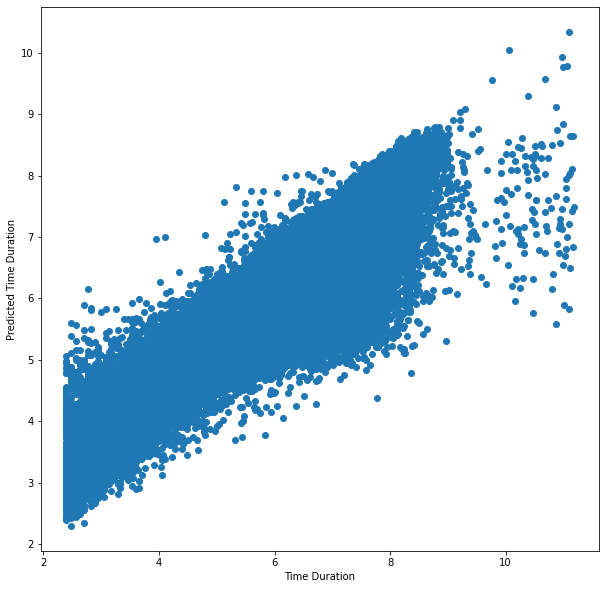

In [164]:
new_df = pd.DataFrame()
new_df['real trip_duration'] = y_train
new_df['predicted trip_duration'] = y_pre_train_xgb
new_df = new_df[['real trip_duration', 'predicted trip_duration']]
new_df.head()

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_train, y_pre_train_xgb)
ax.set_xlabel("Time Duration")
ax.set_ylabel("Predicted Time Duration")
#plt.show()
plt.savefig('xgboost_train.jpg',bbox_inches='tight')

In [165]:
y_pre_val_xgb = model_xgb_tun.predict(dvalid_)
error = y_pre_val_xgb - y_val 
FOM(error,y_val,dfreg=None)

Outputting RMSEP


,R_sqrd,RMSE,Bias,Norm_Bias,Error,Norm_Error
0,0.797161,0.341229,0.000847,0.3634,0.236719,3.866201


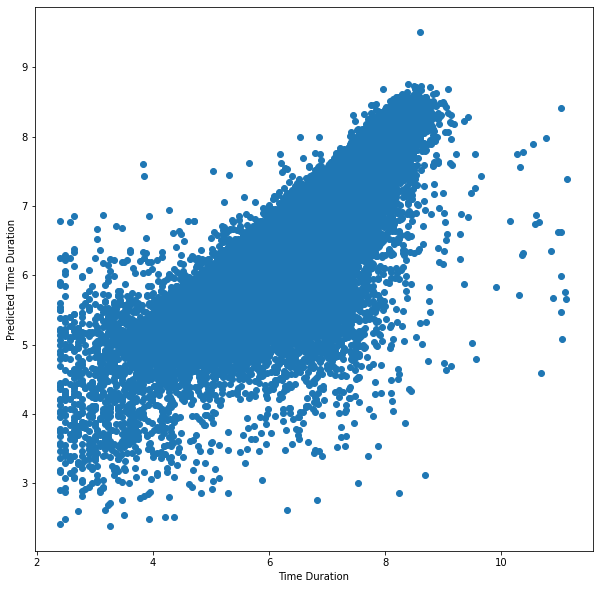

In [166]:
new_df = pd.DataFrame()
new_df['real trip_duration'] = y_val
new_df['predicted trip_duration'] = y_pre_val_xgb
new_df = new_df[['real trip_duration', 'predicted trip_duration']]
new_df.head()

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_val, y_pre_val_xgb)
ax.set_xlabel("Time Duration")
ax.set_ylabel("Predicted Time Duration")
#plt.show()
plt.savefig('xgboost_val.jpg',bbox_inches='tight')

In [167]:
dtest_ = my_pipeline.transform(dtest)
dtest_ = xgb.DMatrix(dtest_)
y_pre_xgb = model_xgb_tun.predict(dtest_)
y_pre_xgb

array([6.936947 , 6.4499297, 6.454231 , ..., 7.701267 , 7.4018536,
       7.324317 ], dtype=float32)

In [168]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,1028.621826
1,id3505355,631.657837
2,id1217141,634.384766
3,id2150126,1089.091187
4,id1598245,270.335449


In [169]:
feature_importance_dict =model_xgb_tun.get_score(importance_type="total_cover")
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)
feature_importance['importance'] = feature_importance['importance']/ feature_importance['importance'].sum()

feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
8,day_of_month,0.214118
9,day_of_week,0.119769
4,dropoff_longitude,0.113163
2,pickup_longitude,0.111971
5,dropoff_latitude,0.111628
3,pickup_latitude,0.111480
1,passenger_count,0.111322
6,pick_month,0.034971
7,hour,0.016167
16,weekday,0.011789
